In [1]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import misc
import numpy as np
import cv2


In [2]:
images = glob.glob(os.path.join('..','data', 'samples', '*'))
images

['..\\data\\samples\\10_left.jpeg',
 '..\\data\\samples\\10_right.jpeg',
 '..\\data\\samples\\13_left.jpeg',
 '..\\data\\samples\\13_right.jpeg',
 '..\\data\\samples\\15_left.jpeg',
 '..\\data\\samples\\15_right.jpeg',
 '..\\data\\samples\\16_left.jpeg',
 '..\\data\\samples\\16_right.jpeg',
 '..\\data\\samples\\17_left.jpeg',
 '..\\data\\samples\\17_right.jpeg']

In [3]:
def smart_crop(im, threshold=30):
    """
    im = image as np array
    threshold = min pixel value for binary-otsu thresholding
    crops eyes out of each image (removes the black background)
    """
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return im[y:y+h,x:x+w]

In [8]:
def preprocess(im, size=(512, 512), threshold=50):
    im = cv2.imread(im)
    im = smart_crop(im, threshold)
    im = smart_resize(im, size)
    return im

In [9]:
5 % 2. 

1.0

In [10]:
def smart_resize(im, size=(512, 512)):
    """
    resize an image while retaining aspect ratio, pad with black background
    """
    h, w, _ = im.shape
    
    if w > h:
        difference = w - h
        top = int((difference/2 + (difference%2)))
        bottom = int(np.ceil(difference/2.))
        left = 0
        right = 0
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    if h > w:
        difference = h - w
        top = 0
        bottom = 0
        left = int((difference/2 + (difference%2)))
        right = int(np.ceil(difference/2.))
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    im = cv2.resize(im, size)
    return im

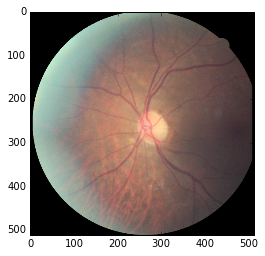

In [11]:
plt.imshow(cv2.cvtColor(preprocess(images[0]), cv2.COLOR_BGR2RGB))

In [12]:
samples = np.array(map(preprocess, images))

In [13]:
samples.shape

(10L, 512L, 512L, 3L)

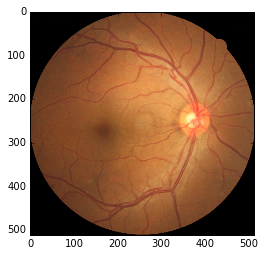

In [34]:
plt.imshow(cv2.cvtColor(samples[9],cv2.COLOR_BGR2RGB))

In [35]:
img = samples[1]

In [36]:
def histogram_equalization(im):
    img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    img_yuv[:,:,0] = cv2.equalizeHist(img[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YCR_CB2RGB)

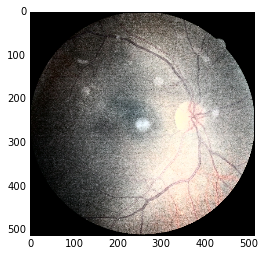

In [38]:
new_img = histogram_equalization(img)
plt.imshow(new_img)